In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

In [3]:
# Define the improved UNet model architecture with additional layers
class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()
        self.down1 = self.conv_block(1, 64)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 1024)
        self.down6 = self.conv_block(1024, 2048)  # Additional downsampling layer
        
        self.up1 = self.upconv_block(2048, 1024)  # Adjust input channels to match additional layer
        self.up2 = self.upconv_block(2048, 512)
        self.up3 = self.upconv_block(1024, 256)
        self.up4 = self.upconv_block(512, 128)
        self.up5 = self.upconv_block(256, 64)
        self.final_depth = nn.Conv2d(128, 1, kernel_size=1)  # Depth map output
        self.final_rgb = nn.Conv2d(128, 3, kernel_size=1)    # RGB image output
        
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for RGB output
    
    def conv_block(self, in_channels, out_channels, use_dropout=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),  # Additional convolution layer
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)
    
    def upconv_block(self, in_channels, out_channels, use_dropout=True):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),  # Additional convolution layer
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(F.max_pool2d(d1, 2))
        d3 = self.down3(F.max_pool2d(d2, 2))
        d4 = self.down4(F.max_pool2d(d3, 2))
        d5 = self.down5(F.max_pool2d(d4, 2))
        d6 = self.down6(F.max_pool2d(d5, 2))  # Additional downsampling step
        
        up1 = self.up1(d6)
        up1 = torch.cat((up1, d5), dim=1)
        up2 = self.up2(up1)
        up2 = torch.cat((up2, d4), dim=1)
        up3 = self.up3(up2)
        up3 = torch.cat((up3, d3), dim=1)
        up4 = self.up4(up3)
        up4 = torch.cat((up4, d2), dim=1)
        up5 = self.up5(up4)
        up5 = torch.cat((up5, d1), dim=1)
        
        depth_output = self.final_depth(up5)
        rgb_output = self.sigmoid(self.final_rgb(up5))  # Apply Sigmoid activation
        
        return depth_output, rgb_output

In [ ]:
# Dataset class
class ChairDataset(Dataset):
    def __init__(self, edge_dir, depth_dir, rgb_dir, transform=None):
        self.edge_dir = edge_dir
        self.depth_dir = depth_dir
        self.rgb_dir = rgb_dir
        self.transform = transform
        self.edge_files = os.listdir(edge_dir)
        self.valid_files = self._filter_valid_files()
    
    def _filter_valid_files(self):
        valid_files = []
        for filename in self.edge_files:
            edge_path = os.path.join(self.edge_dir, filename)
            depth_path = os.path.join(self.depth_dir, filename)
            rgb_path = os.path.join(self.rgb_dir, filename)
            if os.path.exists(edge_path) and os.path.exists(depth_path) and os.path.exists(rgb_path):
                valid_files.append(filename)
        return valid_files
    
    def __len__(self):
        return len(self.valid_files)
    
    def __getitem__(self, idx):
        filename = self.valid_files[idx]
        edge_path = os.path.join(self.edge_dir, filename)
        depth_path = os.path.join(self.depth_dir, filename)
        rgb_path = os.path.join(self.rgb_dir, filename)
        
        edge = Image.open(edge_path).convert('L')
        depth = Image.open(depth_path).convert('L')
        rgb = Image.open(rgb_path).convert('RGB')
        
        if self.transform:
            edge = self.transform(edge)
            depth = self.transform(depth)
            rgb = self.transform(rgb)
        
        return edge, depth, rgb


In [ ]:
def train_model(model, dataloader, criterion_depth, criterion_rgb, optimizer, num_epochs=10, device='cuda', depth_weight=1.0, rgb_weight=1.0):
    model.to(device)  # Move the model to the specified device
    model.train()  # Set the model to training mode
    
    for epoch in range(num_epochs):
        running_loss_depth = 0.0
        running_loss_rgb = 0.0
        
        total_samples = 0
        
        for i, data in enumerate(dataloader, 0):
            inputs, depth_targets, rgb_targets = data
            
            # Move inputs and targets to the same device as the model
            inputs = inputs.to(device)
            depth_targets = depth_targets.to(device)
            rgb_targets = rgb_targets.to(device)
            
            # Forward pass
            depth_outputs, rgb_outputs = model(inputs)
            
            # Resize targets to match the output sizes
            depth_targets_resized = F.interpolate(depth_targets, size=depth_outputs.shape[2:], mode='bilinear', align_corners=False)
            rgb_targets_resized = F.interpolate(rgb_targets, size=rgb_outputs.shape[2:], mode='bilinear', align_corners=False)
            
            # Compute losses
            loss_depth = criterion_depth(depth_outputs, depth_targets_resized)
            loss_rgb = criterion_rgb(rgb_outputs, rgb_targets_resized)
            loss = depth_weight * loss_depth + rgb_weight * loss_rgb

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update loss statistics
            running_loss_depth += loss_depth.item()
            running_loss_rgb += loss_rgb.item()

            total_samples += inputs.size(0)
            
            # Print loss after every 20 batches
            if (i + 1) % 20 == 0:
                avg_loss_depth = running_loss_depth / (i + 1)
                avg_loss_rgb = running_loss_rgb / (i + 1)
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] Avg Loss Depth: {avg_loss_depth:.3f}, Avg Loss RGB: {avg_loss_rgb:.3f}")

        # Print average loss for the epoch
        avg_loss_depth = running_loss_depth / len(dataloader)
        avg_loss_rgb = running_loss_rgb / len(dataloader)
        print(f"[Epoch {epoch + 1}] Avg Loss Depth: {avg_loss_depth:.3f}, Avg Loss RGB: {avg_loss_rgb:.3f}")

    print('Finished Training')


In [ ]:
# Data transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset paths
edge_dir = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\edge'
depth_dir = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\depth'
rgb_dir = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\rgb_png'

# Dataset and DataLoader
dataset = ChairDataset(edge_dir, depth_dir, rgb_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Model, loss functions, and optimizer
model = ImprovedUNet().cuda()
criterion_depth = nn.MSELoss()
criterion_rgb = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [104]:
# Train the model
train_model(model, dataloader, criterion_depth, criterion_rgb, optimizer, num_epochs=3, depth_weight=1.0, rgb_weight=1.0)

[Epoch 1, Batch 20] Avg Loss Depth: 0.459, Avg Loss RGB: 0.097
[Epoch 1, Batch 40] Avg Loss Depth: 0.352, Avg Loss RGB: 0.092
[Epoch 1, Batch 60] Avg Loss Depth: 0.300, Avg Loss RGB: 0.088
[Epoch 1, Batch 80] Avg Loss Depth: 0.265, Avg Loss RGB: 0.084
[Epoch 1, Batch 100] Avg Loss Depth: 0.239, Avg Loss RGB: 0.080
[Epoch 1, Batch 120] Avg Loss Depth: 0.222, Avg Loss RGB: 0.078
[Epoch 1, Batch 140] Avg Loss Depth: 0.209, Avg Loss RGB: 0.076
[Epoch 1, Batch 160] Avg Loss Depth: 0.198, Avg Loss RGB: 0.073
[Epoch 1, Batch 180] Avg Loss Depth: 0.189, Avg Loss RGB: 0.072
[Epoch 1, Batch 200] Avg Loss Depth: 0.181, Avg Loss RGB: 0.071
[Epoch 1, Batch 220] Avg Loss Depth: 0.174, Avg Loss RGB: 0.069
[Epoch 1, Batch 240] Avg Loss Depth: 0.169, Avg Loss RGB: 0.068
[Epoch 1, Batch 260] Avg Loss Depth: 0.163, Avg Loss RGB: 0.067
[Epoch 1, Batch 280] Avg Loss Depth: 0.159, Avg Loss RGB: 0.066
[Epoch 1, Batch 300] Avg Loss Depth: 0.154, Avg Loss RGB: 0.065
[Epoch 1, Batch 320] Avg Loss Depth: 0.150, 

In [105]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'improved_model_weights.pth')

Generated images saved to D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_depth.png and D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_rgb.png


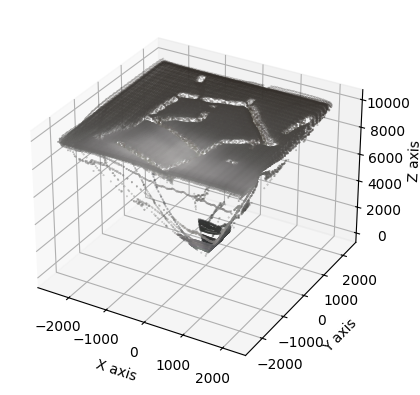

In [10]:
# Function to load an image, perform transformations, and get model predictions
def generate_images(model, edge_image_path, depth_output_path, rgb_output_path, transform=None, device='cuda'):
    model.to(device)  # Move the model to the specified device
    model.eval()  # Set the model to evaluation mode

    # Load and transform the edge image
    edge_image = Image.open(edge_image_path).convert('L')
    if transform:
        edge_image = transform(edge_image)
    edge_image = edge_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Get model predictions
    with torch.no_grad():
        depth_output, rgb_output = model(edge_image)

    # Convert outputs to images
    depth_output = depth_output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
    rgb_output = rgb_output.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert to HWC format and move to CPU

    # Save depth output
    plt.imsave(depth_output_path, depth_output[0], cmap='gray')

    # Normalize and save RGB output
    rgb_output = (rgb_output - rgb_output.min()) / (rgb_output.max() - rgb_output.min())  # Normalize to [0, 1]
    plt.imsave(rgb_output_path, rgb_output)

    print(f"Generated images saved to {depth_output_path} and {rgb_output_path}")

# Example usage
edge_image_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_edge_input.png'
depth_output_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_depth.png'
rgb_output_path = r'D:\Jupyter\3D Construction\Dataset\redwood-3dscan\data\rgbd_extract\00037\output\1_rgb.png'

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load the trained model
load_model = ImprovedUNet()
load_model.load_state_dict(torch.load('improved_model_weights.pth'))

# Generate images
generate_images(load_model, edge_image_path, depth_output_path, rgb_output_path, transform=transform)

def depth_to_point_cloud(depth_map, rgb_image, scale=1000.0, focal_length=500.0):
    height, width = depth_map.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    z = depth_map * scale

    x = (x - width / 2.0) * z / focal_length
    y = (y - height / 2.0) * z / focal_length

    points = np.stack((x, y, z), axis=-1).reshape(-1, 3)
    colors = rgb_image.reshape(-1, 3) / 255.0  # Normalize to [0, 1]

    return points, colors

def generate_3d_point_cloud(model, edge_image_path, transform=None, device='cuda'):
    model.to(device)
    model.eval()

    edge_image = Image.open(edge_image_path).convert('L')
    if transform:
        edge_image = transform(edge_image)
    edge_image = edge_image.unsqueeze(0).to(device)

    with torch.no_grad():
        depth_output, rgb_output = model(edge_image)

    depth_output = depth_output.squeeze(0).cpu().numpy()
    rgb_output = rgb_output.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Normalize depth to range [0, 1]
    depth_output = (depth_output - depth_output.min()) / (depth_output.max() - depth_output.min())
    # Scale depth for better visualization (optional, depends on your data)
    depth_output = depth_output * 10  # You can adjust the scale factor

    # Normalize RGB to range [0, 255] and convert to uint8
    rgb_output = (rgb_output * 255).astype(np.uint8)

    points, colors = depth_to_point_cloud(depth_output[0], rgb_output)

    return points, colors

def visualize_point_cloud_matplotlib(points, colors):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=0.1)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()

# Generate 3D point cloud
points, colors = generate_3d_point_cloud(load_model, edge_image_path, transform=transform)

# Visualize the point cloud using Matplotlib
visualize_point_cloud_matplotlib(points, colors)


In [11]:
def visualize_point_cloud_open3d(points, colors):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    o3d.visualization.draw_geometries([pcd])

# Use this instead of the matplotlib visualization
visualize_point_cloud_open3d(points, colors)